# Artificial Neural Networks and Deep Learning

---

## Homework 2: Semantic Segmentation
This notebook contains one possible structure for the second homework of the AN2DL course. The goal is to perform semantic segmentation on a specific set of images, collected from Mars surface.

## TODO:
* Il test set non presenta particolari augmentations, le immagini sembrano le stesse del train set
* La classe di Background (label = 0) non è inclusa nella valutazione del MeanIoU e pertanto è da escludersi.

* Da questo video (https://www.youtube.com/watch?v=azM57JuQpQI&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE) si nota che viene anche usato un layer di dropout con rate piccolo (0.1) durante la convoluzione: può aiutare?

## ⚙️ Import Libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

seed = 42
# np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [2]:
# Load the entire dataset
data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## 👀 Inspect the dataset
Dataset inspection is meant to find possible outliers in the images, detect duplicates and, more in general, to do everything connected to data cleaning and pre-processing.

[ 558  100   36  575 1500  789 2511 1986 1039  307]


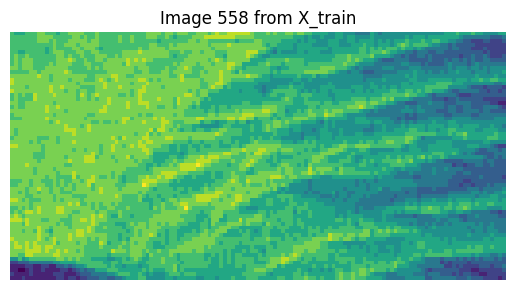

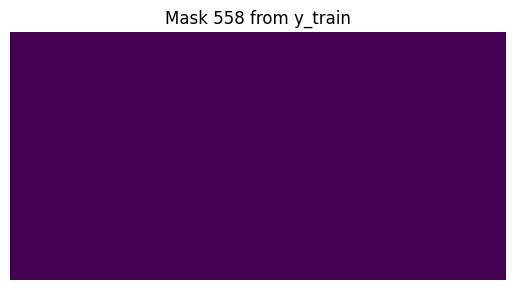

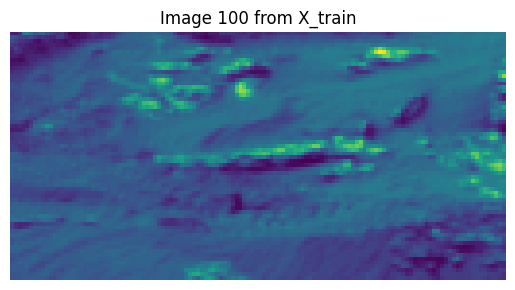

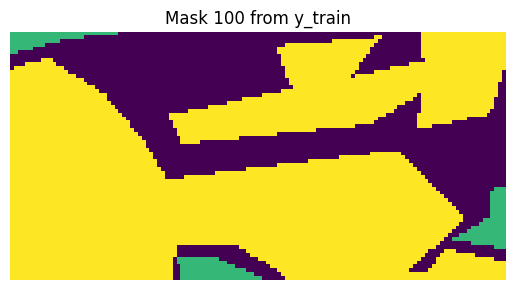

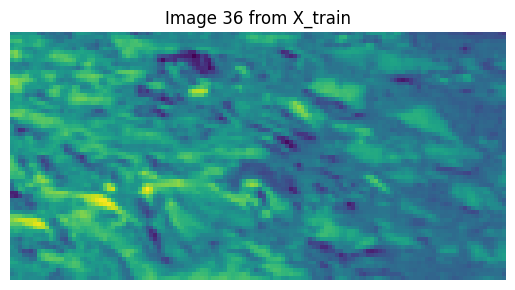

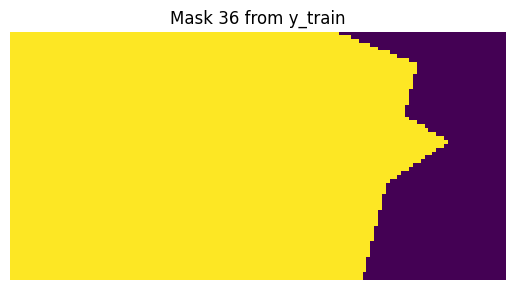

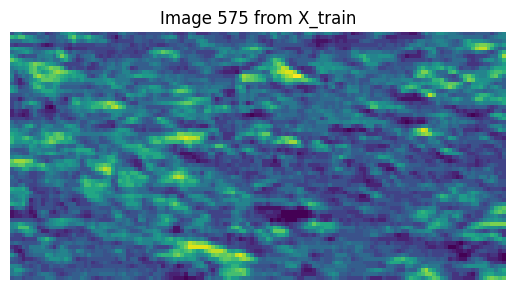

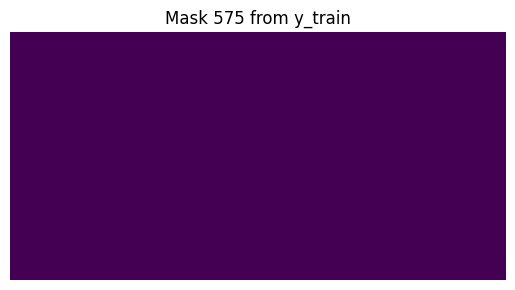

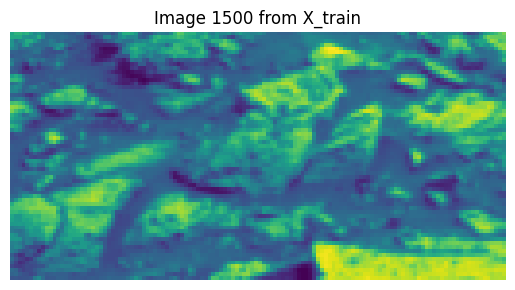

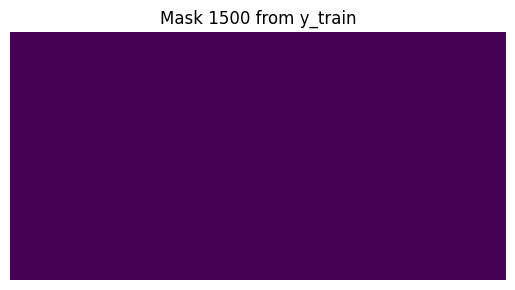

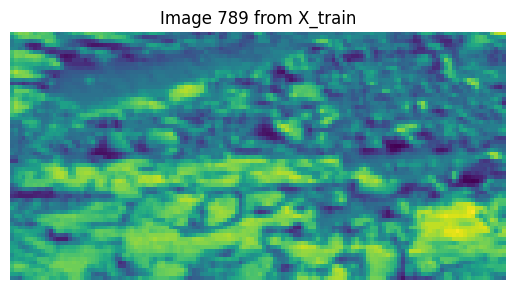

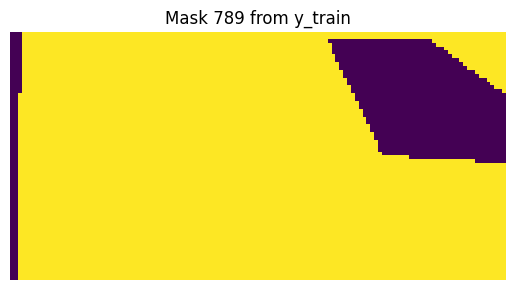

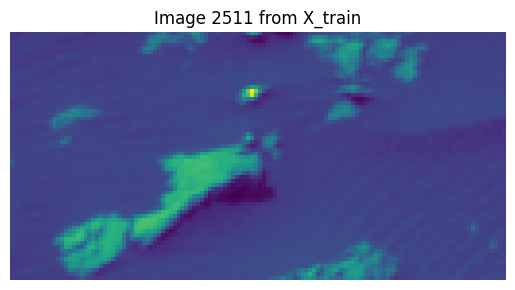

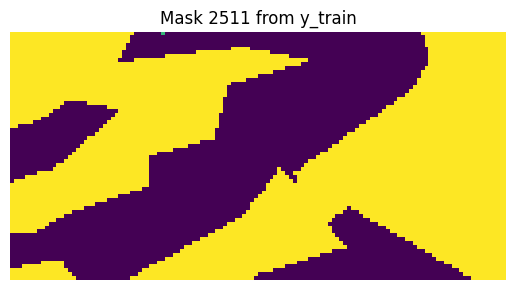

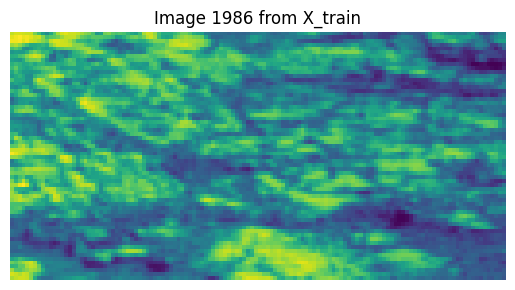

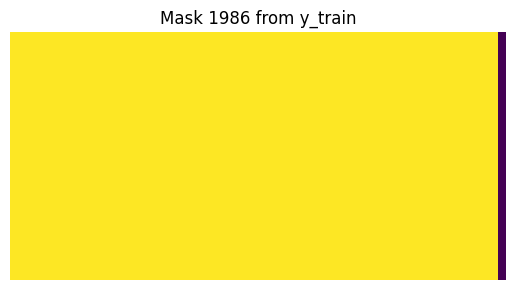

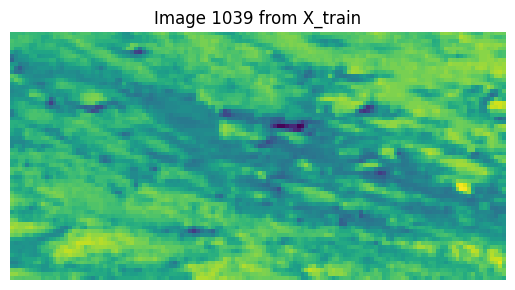

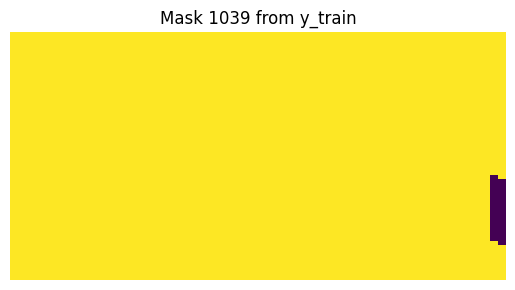

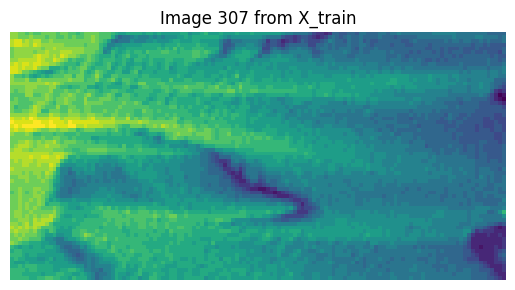

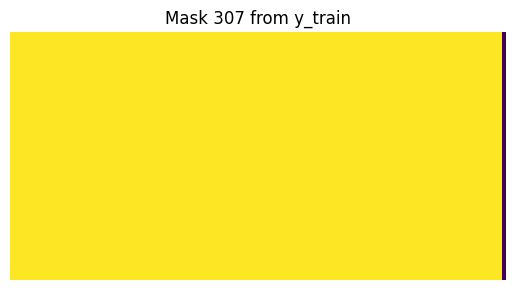

In [3]:
# Create a random index to display every time a different set of images
X_train_size = X_train.shape[0]
random_indices = np.random.randint(0, X_train_size, size = 10)
print(random_indices)

# Plot the image
for index in random_indices:
    plt.imshow(X_train[index])
    plt.title(f"Image {index} from X_train")
    plt.axis('off')
    plt.show()
    
    plt.imshow(y_train[index])
    plt.title(f"Mask {index} from y_train")
    plt.axis('off')
    plt.show()

### 🧹 Remove the Outliers
Analysing the *X_train* and *y_train* sets, it is possible to notice some outliers. For example, there are some pictures (e.g. the one with index 62) contains the picture of an alien. 

By understanding both the pictures and the masks, the masks seems to be the same even if the alien picture is flipped. So we can scan all the masks that are the same of picture 62 and then remove them from the dataset.

In [4]:
# This function establish if image1 and image2 are the same images, pixel-wise.
def are_same_mask (image1, image2):
    if image1.shape != image2.shape:
        print("[ERROR] The images are not the same size.")
        return False
    return np.array_equal(image1, image2)

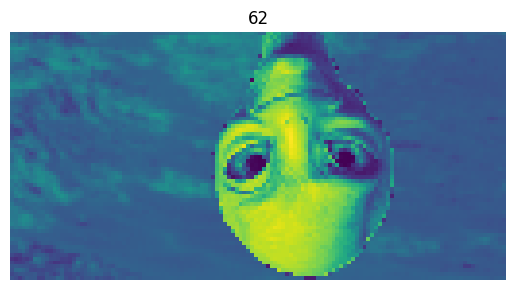

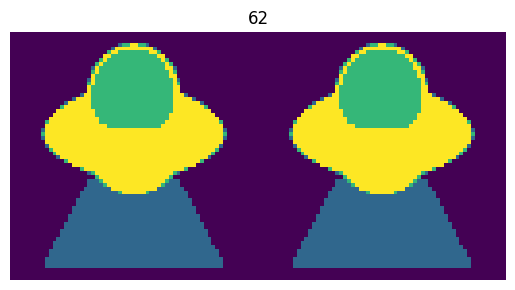

In [5]:
# Show the first picture of an alien
first_alien_index = 62
alien_indices = []
alien_indices.append(first_alien_index)

plt.imshow(X_train[first_alien_index])
plt.title(first_alien_index)
plt.axis('off')
plt.show()

plt.imshow(y_train[first_alien_index])
plt.title(first_alien_index)
plt.axis('off')
plt.show()

In [6]:
# Detect all the images with the same masks as of the first alien
for i in range(X_train_size):
    if i != first_alien_index and are_same_mask(y_train[first_alien_index], y_train[i]):
        alien_indices.append(i)

print(f"{len(alien_indices)} images have the same mask of the first alien picture:")
print(alien_indices)

110 images have the same mask of the first alien picture:
[62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


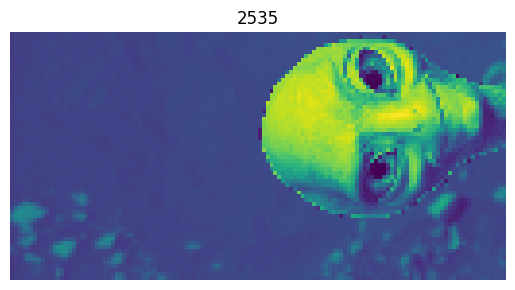

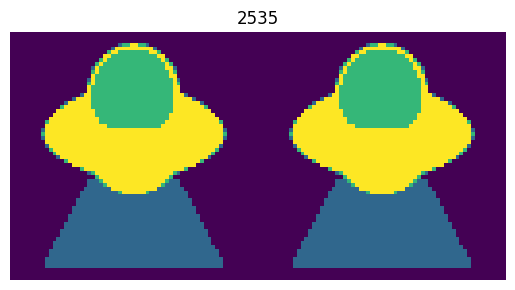

In [7]:
# Display one random image and the corresponding mask containing an alien
random_alien = alien_indices[np.random.randint(0, len(alien_indices))]

plt.imshow(X_train[random_alien])
plt.title(random_alien)
plt.axis('off')
plt.show()

plt.imshow(y_train[random_alien])
plt.title(random_alien)
plt.axis('off')
plt.show()

In [8]:
# Delete from X_train and y_train all the images with index in alien_indices
X_train = np.delete(X_train, alien_indices, axis=0)
y_train = np.delete(y_train, alien_indices, axis=0)

print("Shape of X_train without aliens: ", X_train.shape)
print("Shape of y_train without aliens: ", y_train.shape)

Shape of X_train without aliens:  (2505, 64, 128)
Shape of y_train without aliens:  (2505, 64, 128)


## 🪓 Split into training and validation set
The training set provided via the arrays *X_train* and *y_train* should be splitted into a new effective training set and a validation set.

In [9]:
# Split into training and validation set with a 80/20 ratio.
X_train, X_val, y_train, y_val = train_test_split (
    X_train, y_train, test_size = 0.20, random_state = seed
)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (2004, 64, 128)
y_train shape:  (2004, 64, 128)
X_val shape:  (501, 64, 128)
y_val shape:  (501, 64, 128)


In [10]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Retrieve the shape of the input
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


## 🛠️ Models and Experiments
A first experiment of the model is done by building from scratch the U-Net architecture.

In [11]:
# Define network hyperparameters
batch_size = 64
learning_rate = 1e-3
epochs = 1000

print("Batch size: ", batch_size)
print("Initial learning rate: ", learning_rate)
print("Epochs: ", epochs)

Batch size:  64
Initial learning rate:  0.001
Epochs:  1000


In [12]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1),
                       bias_regularizer=regularizers.L2(1e-4), kernel_regularizer=regularizers.L2(1e-5))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [13]:
def get_unet_model(input_shape=(64, 128, 3), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 64, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 128, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 256, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck
    bottleneck = unet_block(d3, 512, name='bottleneck')

    # Upsampling path
    u3 = tfkl.UpSampling2D()(bottleneck)
    u3 = tfkl.Concatenate()([u3, down_block_3])
    u3 = unet_block(u3, 256, name='up_block3_')
    
    u2 = tfkl.UpSampling2D()(u3)
    u2 = tfkl.Concatenate()([u2, down_block_2])
    u2 = unet_block(u2, 128, name='up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    u1 = tfkl.Concatenate()([u1, down_block_1])
    u1 = unet_block(u1, 64, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │     1,024 │ down_block3_c… │   Y 

 Total params: 7,793,285 (29.73 MB)

 Trainable params: 7,787,653 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

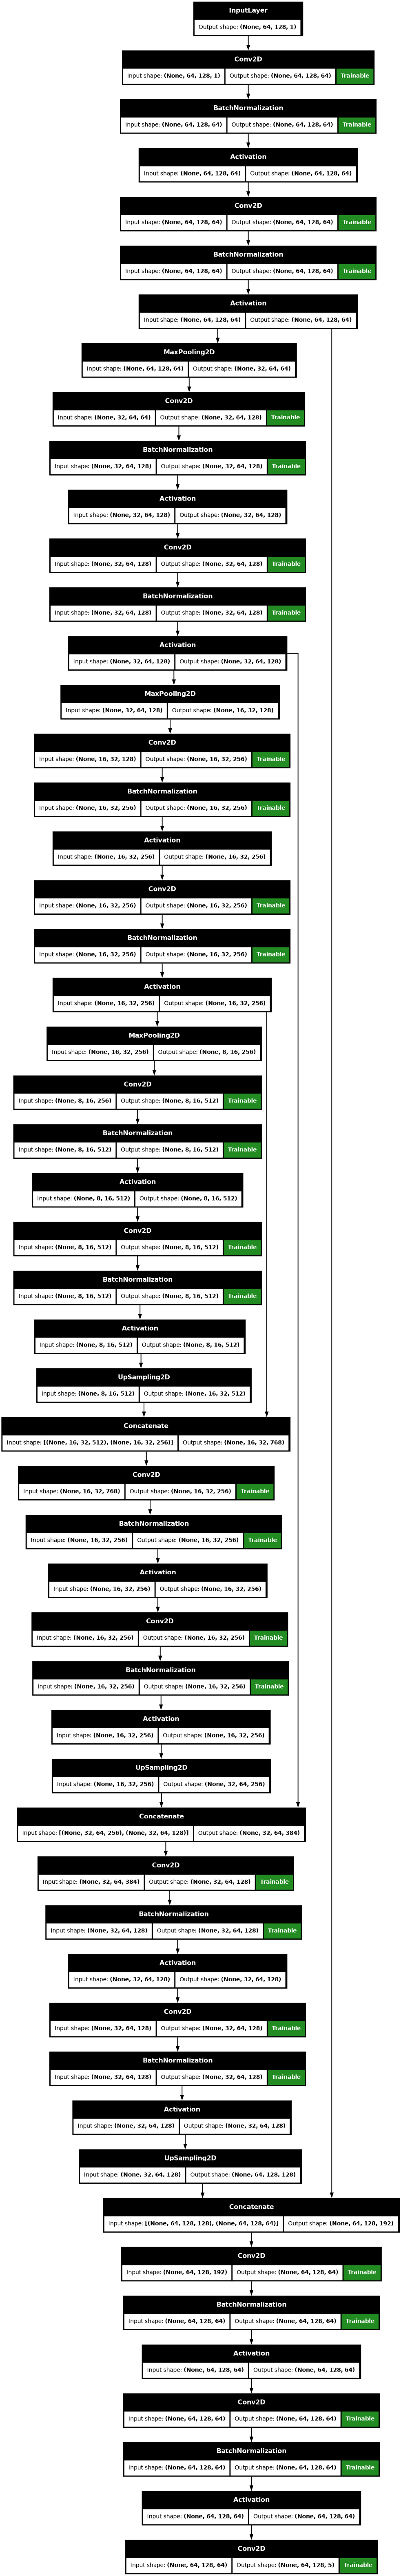

In [14]:
model = get_unet_model(input_shape=input_shape, num_classes=num_classes)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, show_shapes=True, dpi=70)

In [15]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [16]:
# Define custom Mean Intersection Over Union metric
# By default, no classes are excluded.
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_io_u", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [17]:
# Define the metric of mean intersection over union
# As suggested in the exercise session, a custom MeanIoU is suggested
# Class 0 (Background) is excluded from the computation of the MeanIoU, as reported in "Data" section
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])

In [18]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, original_image, original_mask, num_classes, frequency=5):
        super().__init__()
        self.original_image = original_image   # Define the original image
        self.original_mask = original_mask     # Define the original mask
        self.num_classes = num_classes         # Define the number of classes
        self.frequency = frequency             # Define the visualization frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = np.expand_dims(self.original_image, axis=0)  # Add batch dimension
            pred = self.model.predict(image, verbose=0)            
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.original_image)
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(apply_colormap(self.original_mask, colormap))
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()            

In [19]:
# Compile the model
print("Compiling model...")
model.compile (
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(learning_rate),
    metrics=["accuracy", mean_iou]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [20]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping (
    monitor='val_accuracy',
    mode='max',
    patience=30,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau (
    monitor='val_loss',
    mode='min',
    patience=10,
    factor=0.1
)

random_viz = np.random.randint(0, X_val.shape[0])
print("Showing evolution on image", random_viz)
viz_callback = VizCallback(X_val[random_viz], y_val[random_viz], num_classes)

callbacks = [early_stopping, reduce_lr, viz_callback]

Showing evolution on image 211


Epoch 1/1000


I0000 00:00:1732991026.224946      92 service.cc:145] XLA service 0x7baf60002460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732991026.225013      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1732991029.798054      92 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


 1/63 ━━━━━━━━━━━━━━━━━━━━ 29:00 28s/step - accuracy: 0.1568 - loss: 2.1399 - mean_io_u: 0.0670

I0000 00:00:1732991044.415438      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3755 - loss: 1.4591 - mean_io_u: 0.1738

W0000 00:00:1732991052.432917      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.3765 - loss: 1.4566 - mean_io_u: 0.1742

W0000 00:00:1732991068.783751      94 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1732991072.583524      93 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


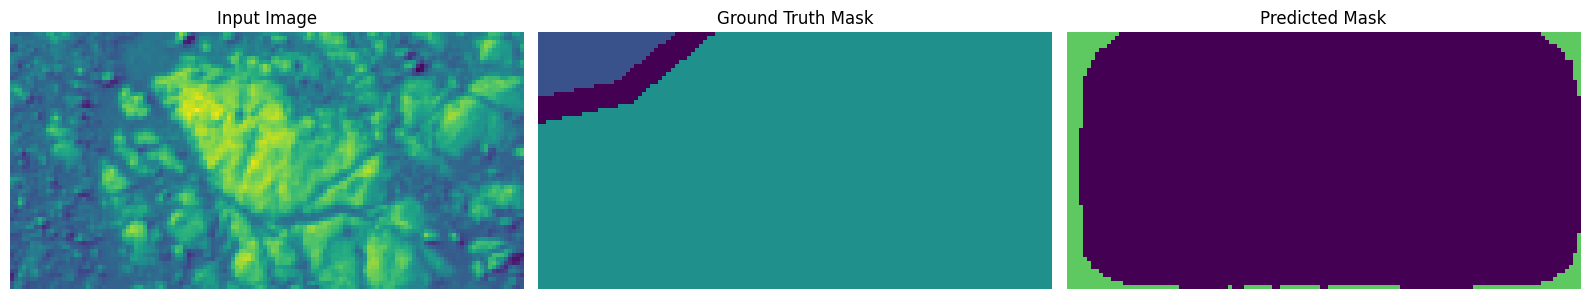

63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 534ms/step - accuracy: 0.3775 - loss: 1.4541 - mean_io_u: 0.1747 - val_accuracy: 0.2375 - val_loss: 6.1904 - val_mean_io_u: 0.0089 - learning_rate: 0.0010
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.5360 - loss: 1.1323 - mean_io_u: 0.2634 - val_accuracy: 0.1979 - val_loss: 9.3432 - val_mean_io_u: 0.0656 - learning_rate: 0.0010
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.5847 - loss: 1.0633 - mean_io_u: 0.2982 - val_accuracy: 0.1979 - val_loss: 5.4850 - val_mean_io_u: 0.0656 - learning_rate: 0.0010
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.6402 - loss: 0.9576 - mean_io_u: 0.3520 - val_accuracy: 0.1979 - val_loss: 5.9128 - val_mean_io_u: 0.0657 - learning_rate: 0.0010
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.6399 - loss: 0.9373 - mean_io_u: 0.3510 - val_accuracy: 0.1980 - val_loss: 4.6370 - val_mean_io_u: 0.0526 - learning_rate: 0.0010
Epoch 6/1000
63/63 ━━━━━━━

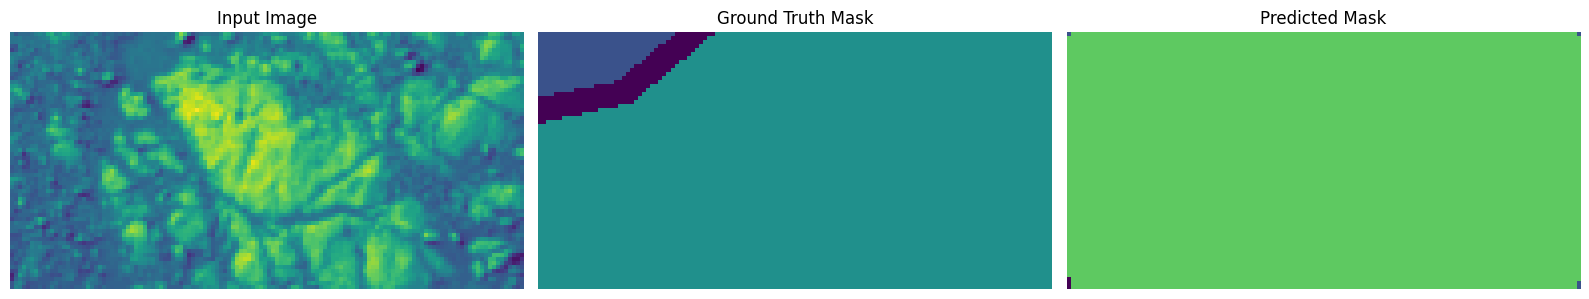

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.6719 - loss: 0.8850 - mean_io_u: 0.3773 - val_accuracy: 0.2114 - val_loss: 3.8521 - val_mean_io_u: 0.0602 - learning_rate: 0.0010
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.6812 - loss: 0.8580 - mean_io_u: 0.3890 - val_accuracy: 0.2754 - val_loss: 3.0016 - val_mean_io_u: 0.1007 - learning_rate: 0.0010
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.6854 - loss: 0.8479 - mean_io_u: 0.3872 - val_accuracy: 0.2912 - val_loss: 2.6322 - val_mean_io_u: 0.1034 - learning_rate: 0.0010
Epoch 9/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.7044 - loss: 0.8042 - mean_io_u: 0.4093 - val_accuracy: 0.5351 - val_loss: 1.6290 - val_mean_io_u: 0.2805 - learning_rate: 0.0010
Epoch 10/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.6981 - loss: 0.8298 - mean_io_u: 0.3983 - val_accuracy: 0.3632 - val_loss: 2.3317 - val_mean_io_u: 0.1245 - learning_rate: 0.0010
Epoch 11/1000
63/63 ━━━━━━

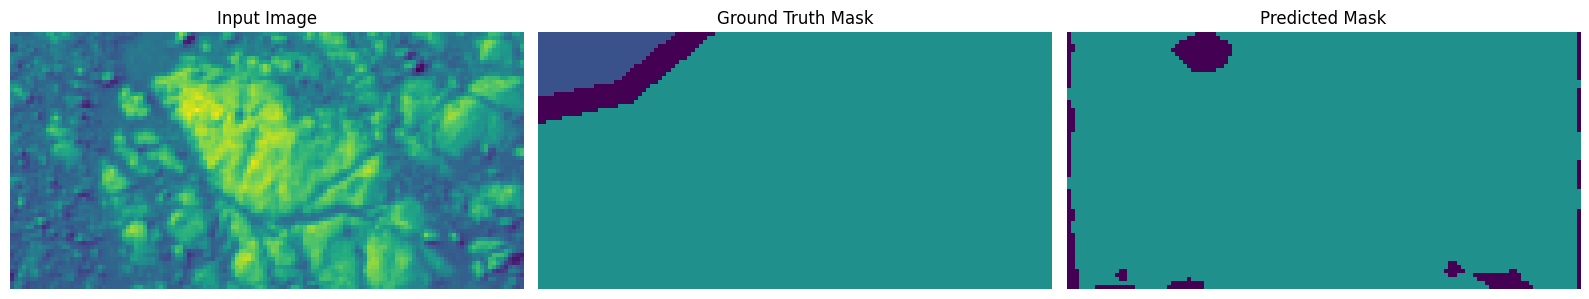

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.7101 - loss: 0.7974 - mean_io_u: 0.4122 - val_accuracy: 0.5015 - val_loss: 1.5241 - val_mean_io_u: 0.2212 - learning_rate: 0.0010
Epoch 12/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7114 - loss: 0.7858 - mean_io_u: 0.4143 - val_accuracy: 0.6295 - val_loss: 1.1691 - val_mean_io_u: 0.3193 - learning_rate: 0.0010
Epoch 13/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7161 - loss: 0.7716 - mean_io_u: 0.4161 - val_accuracy: 0.4583 - val_loss: 1.7542 - val_mean_io_u: 0.1701 - learning_rate: 0.0010
Epoch 14/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7241 - loss: 0.7589 - mean_io_u: 0.4266 - val_accuracy: 0.6239 - val_loss: 1.2958 - val_mean_io_u: 0.3083 - learning_rate: 0.0010
Epoch 15/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7259 - loss: 0.7514 - mean_io_u: 0.4258 - val_accuracy: 0.6170 - val_loss: 1.3569 - val_mean_io_u: 0.3040 - learning_rate: 0.0010
Epoch 16/1000
63/63 ━━━

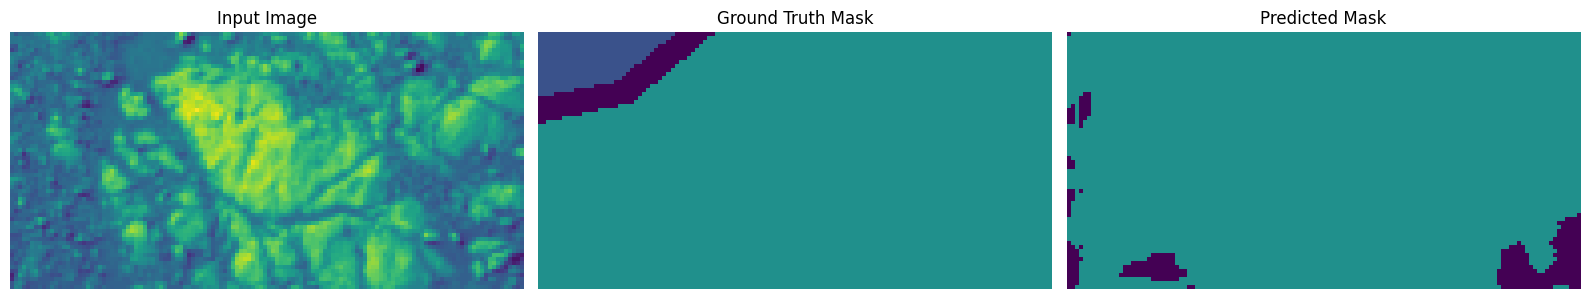

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7335 - loss: 0.7280 - mean_io_u: 0.4331 - val_accuracy: 0.4494 - val_loss: 1.8820 - val_mean_io_u: 0.1684 - learning_rate: 0.0010
Epoch 17/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7415 - loss: 0.7187 - mean_io_u: 0.4393 - val_accuracy: 0.6705 - val_loss: 0.9663 - val_mean_io_u: 0.3575 - learning_rate: 0.0010
Epoch 18/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7401 - loss: 0.7095 - mean_io_u: 0.4379 - val_accuracy: 0.5717 - val_loss: 1.2260 - val_mean_io_u: 0.2664 - learning_rate: 0.0010
Epoch 19/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7334 - loss: 0.7225 - mean_io_u: 0.4281 - val_accuracy: 0.7422 - val_loss: 0.7654 - val_mean_io_u: 0.4322 - learning_rate: 0.0010
Epoch 20/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7484 - loss: 0.6884 - mean_io_u: 0.4451 - val_accuracy: 0.7406 - val_loss: 0.7598 - val_mean_io_u: 0.4337 - learning_rate: 0.0010
Epoch 21/1000
63/63 ━━━

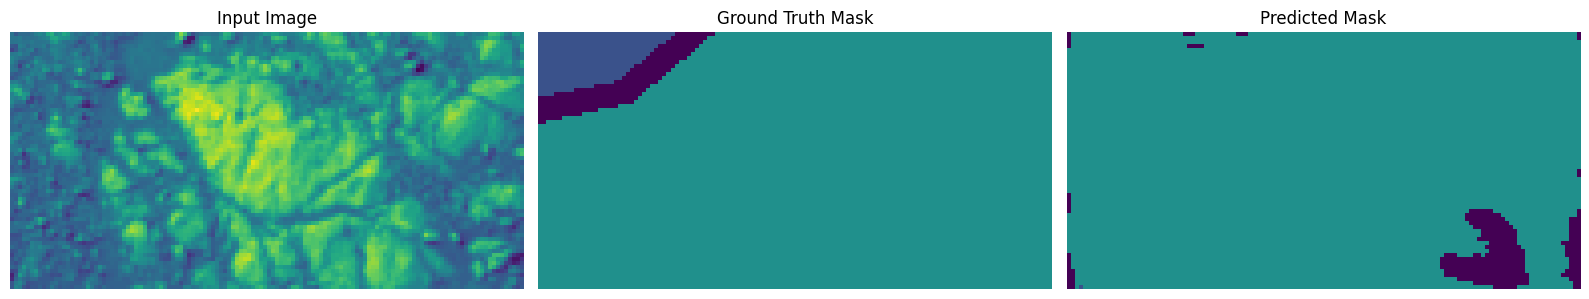

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.7516 - loss: 0.6819 - mean_io_u: 0.4499 - val_accuracy: 0.6259 - val_loss: 1.2222 - val_mean_io_u: 0.3096 - learning_rate: 0.0010
Epoch 22/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7538 - loss: 0.6764 - mean_io_u: 0.4505 - val_accuracy: 0.7377 - val_loss: 0.8030 - val_mean_io_u: 0.4249 - learning_rate: 0.0010
Epoch 23/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7528 - loss: 0.6726 - mean_io_u: 0.4509 - val_accuracy: 0.3502 - val_loss: 2.6350 - val_mean_io_u: 0.0782 - learning_rate: 0.0010
Epoch 24/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7496 - loss: 0.6821 - mean_io_u: 0.4466 - val_accuracy: 0.4976 - val_loss: 2.2286 - val_mean_io_u: 0.1824 - learning_rate: 0.0010
Epoch 25/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7590 - loss: 0.6669 - mean_io_u: 0.4551 - val_accuracy: 0.6911 - val_loss: 0.8908 - val_mean_io_u: 0.3837 - learning_rate: 0.0010
Epoch 26/1000
63/63 ━━━

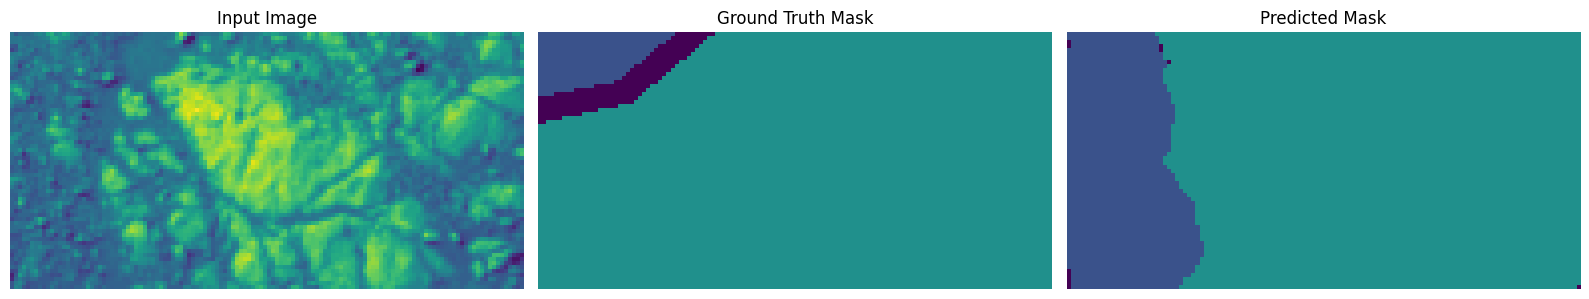

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.7644 - loss: 0.6541 - mean_io_u: 0.4618 - val_accuracy: 0.7360 - val_loss: 0.7981 - val_mean_io_u: 0.4220 - learning_rate: 0.0010
Epoch 27/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7680 - loss: 0.6359 - mean_io_u: 0.4624 - val_accuracy: 0.6532 - val_loss: 0.9668 - val_mean_io_u: 0.3390 - learning_rate: 0.0010
Epoch 28/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7713 - loss: 0.6302 - mean_io_u: 0.4656 - val_accuracy: 0.4716 - val_loss: 1.9487 - val_mean_io_u: 0.1844 - learning_rate: 0.0010
Epoch 29/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7731 - loss: 0.6316 - mean_io_u: 0.4661 - val_accuracy: 0.5517 - val_loss: 1.5978 - val_mean_io_u: 0.2311 - learning_rate: 0.0010
Epoch 30/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.7698 - loss: 0.6373 - mean_io_u: 0.4617 - val_accuracy: 0.6832 - val_loss: 0.9392 - val_mean_io_u: 0.3659 - learning_rate: 0.0010
Epoch 31/1000
63/63 ━━━

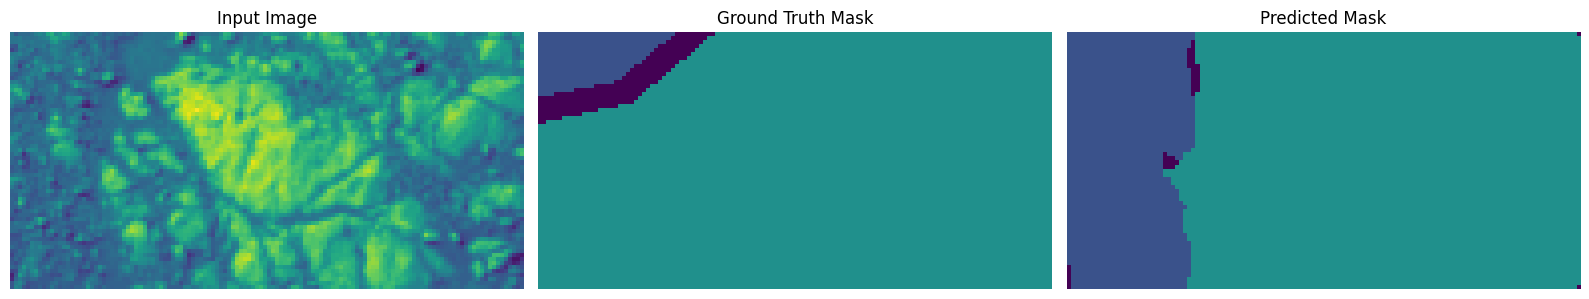

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.7947 - loss: 0.5818 - mean_io_u: 0.4818 - val_accuracy: 0.7333 - val_loss: 0.7627 - val_mean_io_u: 0.4268 - learning_rate: 1.0000e-04
Epoch 32/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8127 - loss: 0.5345 - mean_io_u: 0.4991 - val_accuracy: 0.7701 - val_loss: 0.6680 - val_mean_io_u: 0.4694 - learning_rate: 1.0000e-04
Epoch 33/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8194 - loss: 0.5147 - mean_io_u: 0.5044 - val_accuracy: 0.7772 - val_loss: 0.6487 - val_mean_io_u: 0.4774 - learning_rate: 1.0000e-04
Epoch 34/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8245 - loss: 0.5008 - mean_io_u: 0.5083 - val_accuracy: 0.7789 - val_loss: 0.6462 - val_mean_io_u: 0.4782 - learning_rate: 1.0000e-04
Epoch 35/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8293 - loss: 0.4887 - mean_io_u: 0.5119 - val_accuracy: 0.7793 - val_loss: 0.6492 - val_mean_io_u: 0.4781 - learning_rate: 1.0000e-04
Epo

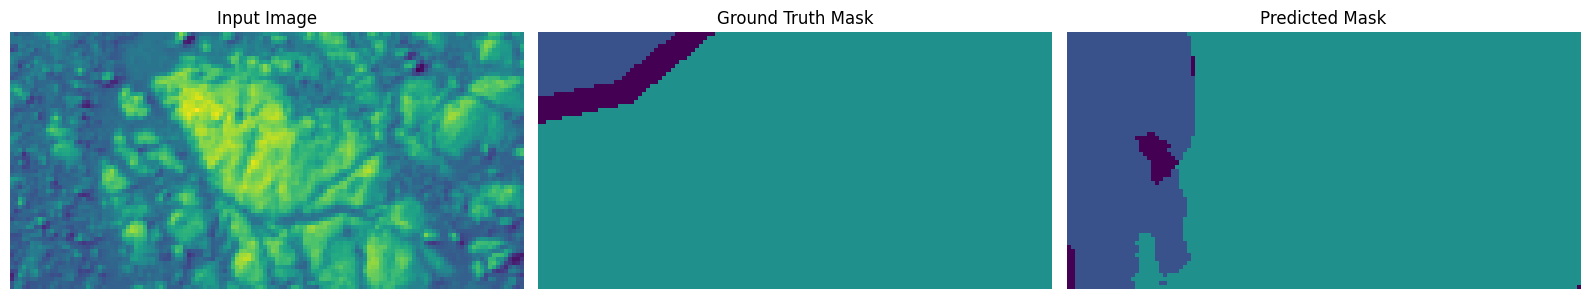

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8343 - loss: 0.4771 - mean_io_u: 0.5155 - val_accuracy: 0.7794 - val_loss: 0.6513 - val_mean_io_u: 0.4775 - learning_rate: 1.0000e-04
Epoch 37/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8391 - loss: 0.4656 - mean_io_u: 0.5190 - val_accuracy: 0.7792 - val_loss: 0.6567 - val_mean_io_u: 0.4770 - learning_rate: 1.0000e-04
Epoch 38/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8440 - loss: 0.4538 - mean_io_u: 0.5225 - val_accuracy: 0.7788 - val_loss: 0.6611 - val_mean_io_u: 0.4758 - learning_rate: 1.0000e-04
Epoch 39/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8492 - loss: 0.4417 - mean_io_u: 0.5263 - val_accuracy: 0.7783 - val_loss: 0.6659 - val_mean_io_u: 0.4741 - learning_rate: 1.0000e-04
Epoch 40/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8546 - loss: 0.4291 - mean_io_u: 0.5301 - val_accuracy: 0.7782 - val_loss: 0.6683 - val_mean_io_u: 0.4734 - learning_rate: 1.0000e-04
Epo

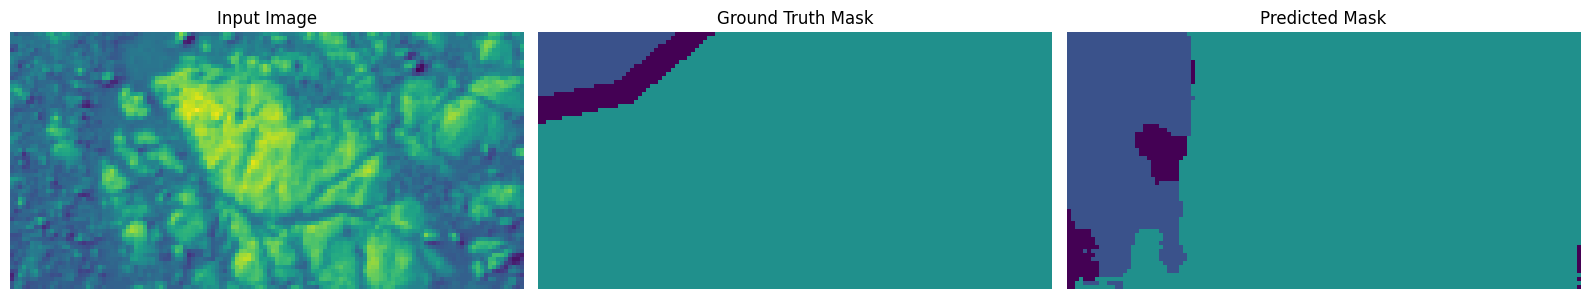

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.8603 - loss: 0.4161 - mean_io_u: 0.5342 - val_accuracy: 0.7776 - val_loss: 0.6772 - val_mean_io_u: 0.4729 - learning_rate: 1.0000e-04
Epoch 42/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8663 - loss: 0.4026 - mean_io_u: 0.5382 - val_accuracy: 0.7775 - val_loss: 0.6811 - val_mean_io_u: 0.4697 - learning_rate: 1.0000e-04
Epoch 43/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8723 - loss: 0.3885 - mean_io_u: 0.5422 - val_accuracy: 0.7760 - val_loss: 0.6924 - val_mean_io_u: 0.4683 - learning_rate: 1.0000e-04
Epoch 44/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8784 - loss: 0.3739 - mean_io_u: 0.5461 - val_accuracy: 0.7753 - val_loss: 0.6985 - val_mean_io_u: 0.4666 - learning_rate: 1.0000e-04
Epoch 45/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8821 - loss: 0.3632 - mean_io_u: 0.5457 - val_accuracy: 0.7746 - val_loss: 0.6988 - val_mean_io_u: 0.4712 - learning_rate: 1.0000e-05
Epo

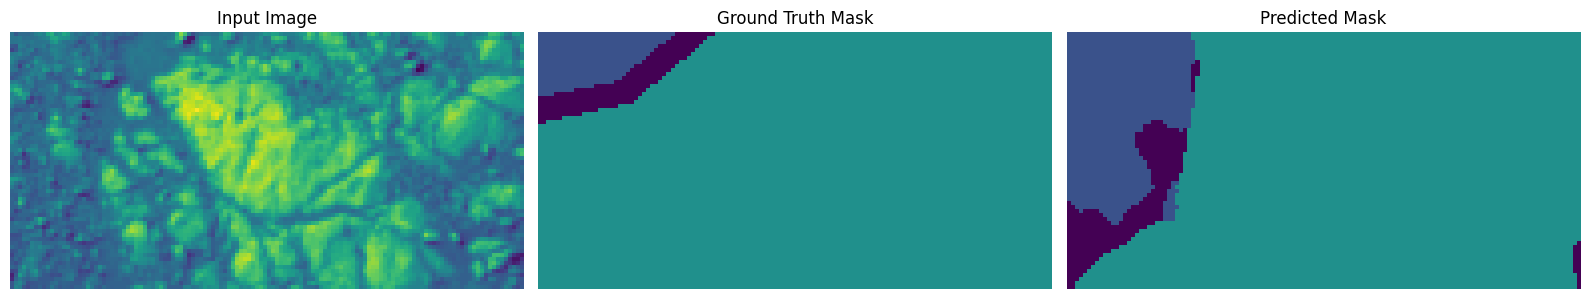

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.8888 - loss: 0.3467 - mean_io_u: 0.5508 - val_accuracy: 0.7730 - val_loss: 0.7050 - val_mean_io_u: 0.4680 - learning_rate: 1.0000e-05
Epoch 47/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8905 - loss: 0.3430 - mean_io_u: 0.5519 - val_accuracy: 0.7717 - val_loss: 0.7108 - val_mean_io_u: 0.4660 - learning_rate: 1.0000e-05
Epoch 48/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8918 - loss: 0.3401 - mean_io_u: 0.5527 - val_accuracy: 0.7709 - val_loss: 0.7156 - val_mean_io_u: 0.4647 - learning_rate: 1.0000e-05
Epoch 49/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8930 - loss: 0.3374 - mean_io_u: 0.5533 - val_accuracy: 0.7704 - val_loss: 0.7192 - val_mean_io_u: 0.4639 - learning_rate: 1.0000e-05
Epoch 50/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8941 - loss: 0.3350 - mean_io_u: 0.5539 - val_accuracy: 0.7701 - val_loss: 0.7222 - val_mean_io_u: 0.4635 - learning_rate: 1.0000e-05
Epo

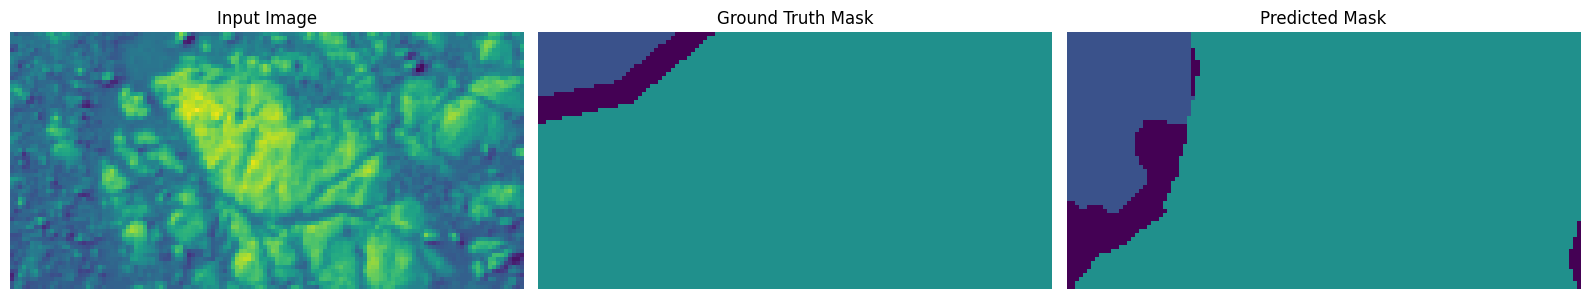

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.8951 - loss: 0.3327 - mean_io_u: 0.5544 - val_accuracy: 0.7698 - val_loss: 0.7251 - val_mean_io_u: 0.4630 - learning_rate: 1.0000e-05
Epoch 52/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8961 - loss: 0.3305 - mean_io_u: 0.5549 - val_accuracy: 0.7695 - val_loss: 0.7275 - val_mean_io_u: 0.4627 - learning_rate: 1.0000e-05
Epoch 53/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8970 - loss: 0.3284 - mean_io_u: 0.5554 - val_accuracy: 0.7693 - val_loss: 0.7300 - val_mean_io_u: 0.4624 - learning_rate: 1.0000e-05
Epoch 54/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8979 - loss: 0.3263 - mean_io_u: 0.5558 - val_accuracy: 0.7691 - val_loss: 0.7322 - val_mean_io_u: 0.4622 - learning_rate: 1.0000e-05
Epoch 55/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8996 - loss: 0.3234 - mean_io_u: 0.5562 - val_accuracy: 0.7680 - val_loss: 0.7351 - val_mean_io_u: 0.4608 - learning_rate: 1.0000e-06
Epo

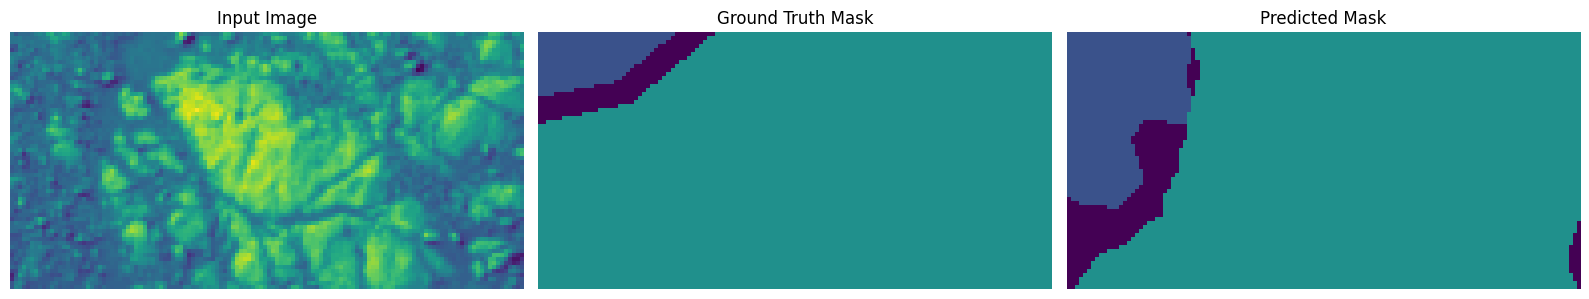

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9000 - loss: 0.3225 - mean_io_u: 0.5567 - val_accuracy: 0.7677 - val_loss: 0.7367 - val_mean_io_u: 0.4603 - learning_rate: 1.0000e-06
Epoch 57/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9003 - loss: 0.3219 - mean_io_u: 0.5570 - val_accuracy: 0.7676 - val_loss: 0.7377 - val_mean_io_u: 0.4602 - learning_rate: 1.0000e-06
Epoch 58/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9005 - loss: 0.3214 - mean_io_u: 0.5572 - val_accuracy: 0.7676 - val_loss: 0.7382 - val_mean_io_u: 0.4602 - learning_rate: 1.0000e-06
Epoch 59/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9006 - loss: 0.3211 - mean_io_u: 0.5574 - val_accuracy: 0.7678 - val_loss: 0.7386 - val_mean_io_u: 0.4602 - learning_rate: 1.0000e-06
Epoch 60/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9008 - loss: 0.3207 - mean_io_u: 0.5575 - val_accuracy: 0.7678 - val_loss: 0.7389 - val_mean_io_u: 0.4603 - learning_rate: 1.0000e-06
Epo

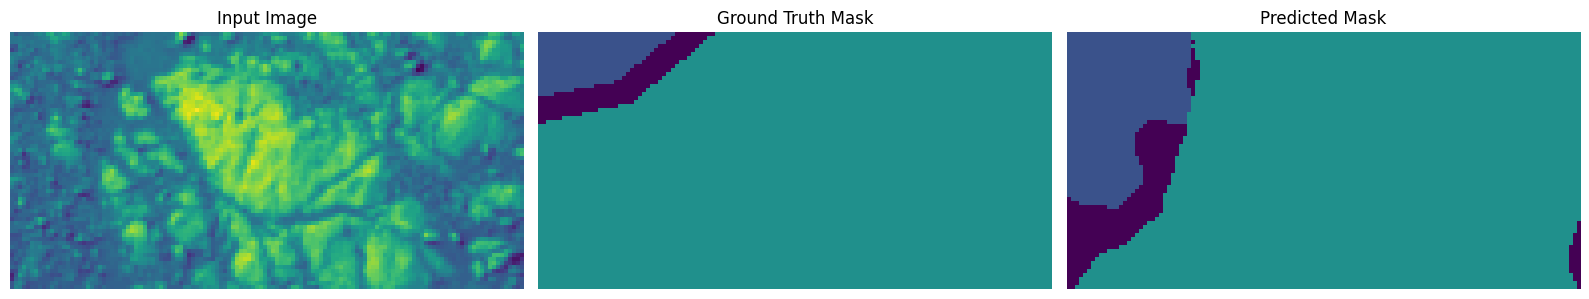

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.9009 - loss: 0.3205 - mean_io_u: 0.5576 - val_accuracy: 0.7679 - val_loss: 0.7391 - val_mean_io_u: 0.4603 - learning_rate: 1.0000e-06
Epoch 62/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9010 - loss: 0.3202 - mean_io_u: 0.5577 - val_accuracy: 0.7679 - val_loss: 0.7394 - val_mean_io_u: 0.4603 - learning_rate: 1.0000e-06
Epoch 63/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9011 - loss: 0.3200 - mean_io_u: 0.5577 - val_accuracy: 0.7679 - val_loss: 0.7397 - val_mean_io_u: 0.4604 - learning_rate: 1.0000e-06
Epoch 64/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9012 - loss: 0.3197 - mean_io_u: 0.5578 - val_accuracy: 0.7679 - val_loss: 0.7399 - val_mean_io_u: 0.4604 - learning_rate: 1.0000e-06
Epoch 65/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.9014 - loss: 0.3194 - mean_io_u: 0.5579 - val_accuracy: 0.7678 - val_loss: 0.7403 - val_mean_io_u: 0.4602 - learning_rate: 1.0000e-07
Epo

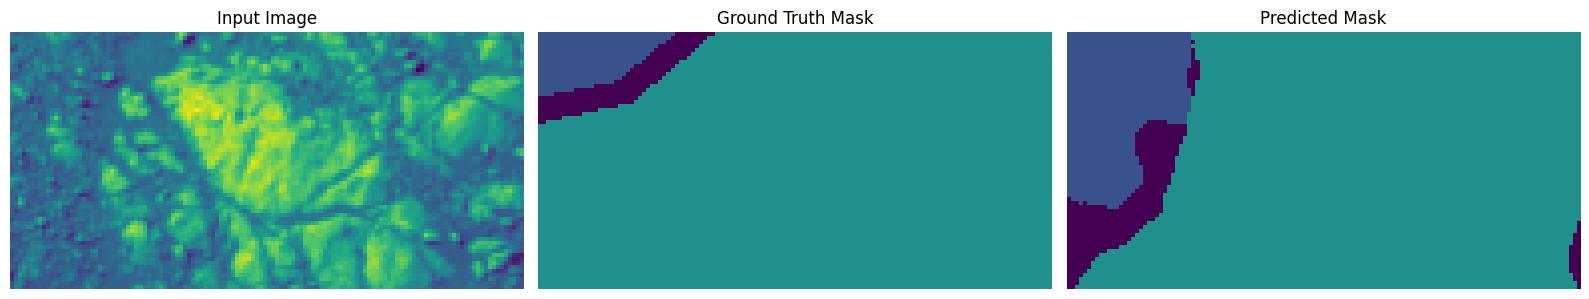

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.9014 - loss: 0.3193 - mean_io_u: 0.5579 - val_accuracy: 0.7678 - val_loss: 0.7406 - val_mean_io_u: 0.4602 - learning_rate: 1.0000e-07
Final validation Mean Intersection Over Union: 47.82%


In [21]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

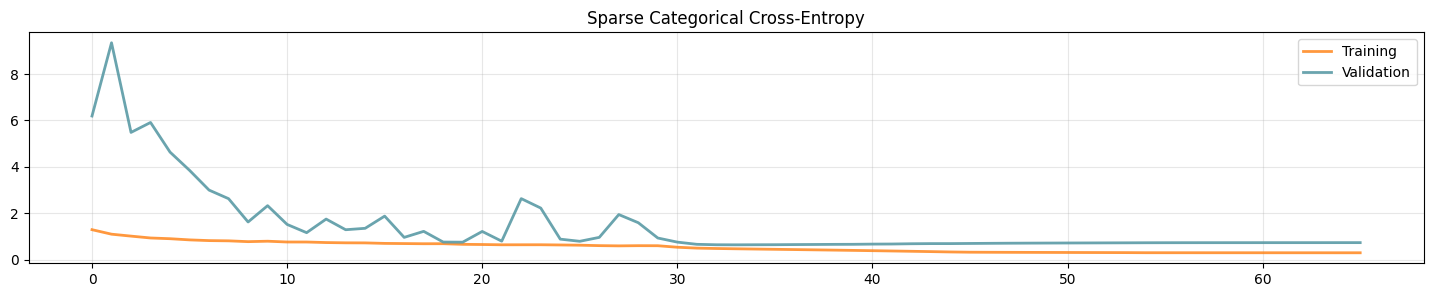

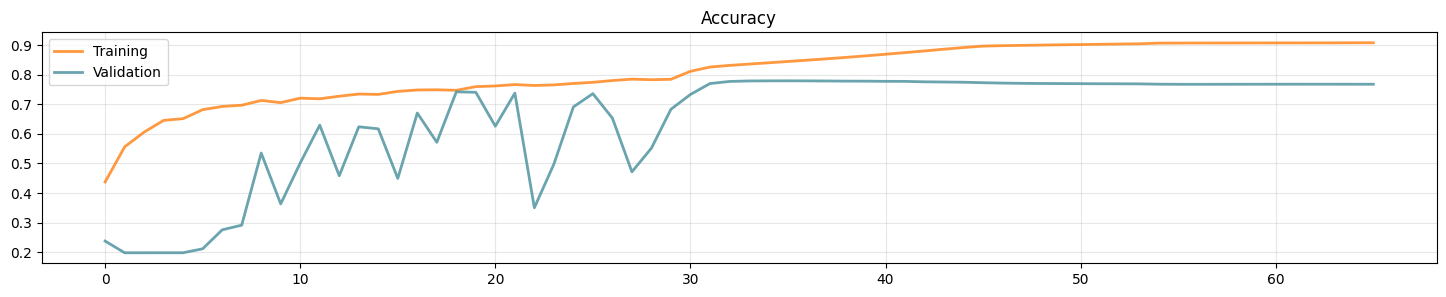

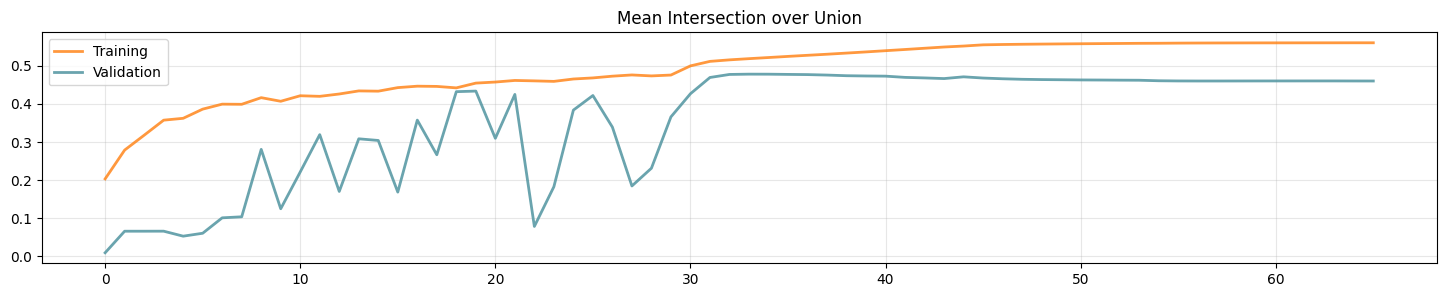

In [22]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Sparse Categorical Cross-Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [23]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241130_183119.keras


## 🕹️ Use the Model - Make Inference

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.

In [24]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [25]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241130_183119.keras


In [26]:
# Custom compiling due to custom metric MeanIOU defined
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       640 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │    36,928 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       256 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │   147,584 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       512 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_conv1 │ (None, 16, 32,  │   295,168 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block3_bn1   │ (None, 16, 32,  │     1,024 │ down_block3_c… │   Y 

 Total params: 7,793,285 (29.73 MB)

 Trainable params: 7,787,653 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [27]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step
Predictions shape: (10022, 64, 128)


In [28]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [29]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print("CSV created in the output folder: ", submission_filename)